In [1]:
import json
import matplotlib.pyplot as plt
import warnings
import scipy as sp
import numpy as np
import pandas as pd

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error,accuracy_score 
from sklearn.metrics import confusion_matrix as sk_cmatrix
# %matplotlib inline

np.random.seed(seed=2019)
warnings.filterwarnings('ignore')
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
aaa = pd.read_csv('Brexit_20190327_G04_traindata.csv')
aaa.head()

,Unnamed: 0,Member,Constituency,Party,Vote386,Vote387,Vote388,Vote389,Vote390,Vote391,Vote392,Vote393,Percentage
0,1,Diane Abbott,Hackney North and Stoke Newington,Lab,No,Aye,No Vote,Aye,Aye,No Vote,Aye,No,0.205
1,2,Debbie Abrahams,Oldham East and Saddleworth,Lab,No,No Vote,No,Aye,Aye,No Vote,Aye,No,0.599
2,3,Nigel Adams,Selby and Ainsty,Con,No Vote,No,No,No,No,No,No,Aye,0.577
3,5,Adam Afriyie,Windsor,Con,Aye,No,No,No,No,No,No,Aye,0.467
4,6,Peter Aldous,Waveney,Con,No,No,Aye,No,No,No,No,No,0.634


In [3]:
raw_train = pd.read_csv('Brexit_20190327_G04_traindata.csv').drop(['Member','Unnamed: 0','Constituency','Party'], axis=1)

raw_train.loc[raw_train['Percentage'] >= 0.4395,'Percentage'] = 1
raw_train.loc[raw_train['Percentage'] < 0.4395,'Percentage'] = 0

y_train = raw_train['Percentage']
X_train = raw_train.drop(['Percentage'], axis=1)
X_train.head()



raw_test = pd.read_csv('Brexit_20190327_G04_testdata.csv').drop(['Member','Unnamed: 0','Constituency','Party'], axis=1)

raw_test.loc[raw_test['Percentage'] >= 0.4395,'Percentage'] = 1
raw_test.loc[raw_test['Percentage'] < 0.4395,'Percentage'] = 0

y_test = raw_test['Percentage']
X_test = raw_test.drop(['Percentage'], axis=1)

In [4]:
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Percentage, dtype: float64

In [5]:

from sklearn import preprocessing 
for f in X_train.columns: 
    if X_train[f].dtype=='object': 
#         print(f)
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_train[f].values)) 
        X_train[f] = lbl.transform(list(X_train[f].values))
        
for f in X_test.columns: 
    if X_test[f].dtype=='object':
#         print(f)
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_test[f].values)) 
        X_test[f] = lbl.transform(list(X_test[f].values))
y_test = pd.to_numeric(y_test)
y_train= pd.to_numeric(y_train)


In [6]:
X_train.head()

,Vote386,Vote387,Vote388,Vote389,Vote390,Vote391,Vote392,Vote393
0,1,0,2,0,0,2,0,1
1,1,2,1,0,0,2,0,1
2,2,1,1,1,1,1,1,0
3,0,1,1,1,1,1,1,0
4,1,1,0,1,1,1,1,1


In [7]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1])
        return -accuracy_score(y, preds)
    
    def fit(self, X, y):
        loss_partial = partial(self.loss, X = X, y = y)
        initial_coef = [0.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [42]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,KFold

xgb_params = {
#     'objective': 'binary:logistic',
    'eval_metric': 'rmse',
    'seed': 2019,
    'eta': 0.0123,
#     'subsample': 0.8,
#     'colsample_bytree': 0.85,
    'tree_method': 'hist',
    'silent': 1,
    
}
import lightgbm as lgb

lgb_params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
#           'max_depth': 9,
          'learning_rate': 0.004,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_samples': 150,
#           'min_child_weight': 0.02,
#           'lambda_l2': 0.0475,
#           'verbosity': -1,
          'data_random_seed': 17
    
}

def run_xlgb(params1, params2, X_train, X_test,y_train,y_test):
    n_splits = 10
    verbose_eval = 1000
    num_rounds = 10000
    early_stop = 20

    kf =StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits),dtype=np.int8)
   
    i = 0

    for train_idx, valid_idx in kf.split(X_train, y_train):
#         print(train_idx)
        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]
        
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[valid_idx]

#         d_train1 = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
#         d_valid1 = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

#         watchlist1 = [(d_train1, 'train'), (d_valid1, 'valid')]
#         print('training XGB:')
#         model1 = xgb.train(dtrain=d_train1, num_boost_round=num_rounds, evals=watchlist1,early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params1)

#         valid_pred1 = model1.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model1.best_ntree_limit)
#         test_pred1 = model1.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model1.best_ntree_limit)
#         print('acc of xgb:')
#         print(accuracy_score(y_test, np.round(test_pred1).astype(np.int8)))
# #         print(test_pred1)
#         oof_train[valid_idx] = valid_pred1
#         oof_test[:, i] = np.round(test_pred1)

        ####################


        d_train2 = lgb.Dataset(X_tr, label=y_tr)
        d_valid2 = lgb.Dataset(X_val, label=y_val)
#         lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        watchlist2 = [d_train2, d_valid2]
        print('training LGB:')
                  
        model2 = lgb.train(params2,
                      train_set=d_train2,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist2,
                      verbose_eval=verbose_eval,
                      )

        valid_pred2 = model2.predict(X_val, num_iteration=model2.best_iteration)
        test_pred2 = model2.predict(X_test, num_iteration=model2.best_iteration)

        oof_train[valid_idx] = valid_pred2
        oof_test[:, i] = np.round(test_pred2)
        print('acc of lgb:')
        print(accuracy_score(y_test, np.round(test_pred2).astype(np.int8)))
        
        i += 1
    return oof_train, oof_test

oof_train, oof_test = run_xlgb(xgb_params,lgb_params, X_train, X_test,y_train,y_test)



training LGB:
[1000]	training's rmse: 0.31656	valid_1's rmse: 0.3225
[2000]	training's rmse: 0.308514	valid_1's rmse: 0.327464
[3000]	training's rmse: 0.304477	valid_1's rmse: 0.330616
[4000]	training's rmse: 0.301986	valid_1's rmse: 0.330228
[5000]	training's rmse: 0.299979	valid_1's rmse: 0.331771
[6000]	training's rmse: 0.298252	valid_1's rmse: 0.334051
[7000]	training's rmse: 0.296732	valid_1's rmse: 0.334935
[8000]	training's rmse: 0.295463	valid_1's rmse: 0.335686
[9000]	training's rmse: 0.294408	valid_1's rmse: 0.33582
[10000]	training's rmse: 0.293444	valid_1's rmse: 0.337033
acc of lgb:
0.7593582887700535
training LGB:
[1000]	training's rmse: 0.315236	valid_1's rmse: 0.335131
[2000]	training's rmse: 0.308457	valid_1's rmse: 0.337275
[3000]	training's rmse: 0.305004	valid_1's rmse: 0.339916
[4000]	training's rmse: 0.302408	valid_1's rmse: 0.341428
[5000]	training's rmse: 0.300075	valid_1's rmse: 0.34356
[6000]	training's rmse: 0.298315	valid_1's rmse: 0.345366
[7000]	training's

In [43]:

import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error,accuracy_score 
from sklearn.metrics import confusion_matrix as sk_cmatrix


optR = OptimizedRounder()
optR.fit(oof_train, y_train.values)
coefficients = optR.coefficients()
valid_pred = optR.predict(oof_train, coefficients)
acc_val = accuracy_score(y_train, valid_pred)
print(acc_val)


test_predictions = optR.predict(oof_test.mean(axis=1), coefficients).astype(np.int8)
acc_test = accuracy_score(y_test, test_predictions)
print(acc_test)


0.8497757847533632
0.786096256684492


In [33]:
coefficients

array([0.48125])

In [34]:
test_predictions

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int8)

In [26]:
print(f'test pred distribution: {Counter(test_predictions)}')


test pred distribution: Counter({1: 163, 0: 24})


In [9]:
### XGB ### 
import xgboost as xgb

xgb_params = {
#     'objective': 'binary:logistic',
    'eval_metric': 'rmse',
    'seed': 2019,
    'eta': 0.0123,
#     'subsample': 0.8,
#     'colsample_bytree': 0.85,
    'tree_method': 'hist',
    'silent': 1,
    
}

xgb_train = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
xgb_test = xgb.DMatrix(data=X_test, label=y_test, feature_names=X_test.columns)

watchlist1 = [(xgb_train, 'train'), (xgb_test, 'test')]
model_xgb = xgb.train(dtrain=xgb_train, num_boost_round=10000, evals=watchlist1,early_stopping_rounds=20, verbose_eval=100, params=xgb_params)
# valid_pred1 = model1.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model1.best_ntree_limit)
test_pred_xgb = model_xgb.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model_xgb.best_ntree_limit)
print('acc of xgb:')
print(accuracy_score(y_test, np.round(test_pred_xgb).astype(np.int8)))


[0]	train-rmse:0.496199	test-rmse:0.496927
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[100]	train-rmse:0.320019	test-rmse:0.382729
Stopping. Best iteration:
[132]	train-rmse:0.305246	test-rmse:0.380561

acc of xgb:
0.7754010695187166


In [17]:
xgb.cv(xgb_params, dtrain=xgb_train, num_boost_round=10000, nfold=10, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.496249,0.000069,0.496609,0.000391
1,0.492551,0.000137,0.493300,0.000789
2,0.488918,0.000209,0.490023,0.001176
3,0.485338,0.000281,0.486827,0.001574
4,0.481823,0.000352,0.483673,0.001961
5,0.478350,0.000406,0.480606,0.002352
6,0.474944,0.000450,0.477582,0.002735
7,0.471588,0.000506,0.474629,0.003125
8,0.468293,0.000560,0.471713,0.003504
9,0.465050,0.000619,0.468882,0.003894


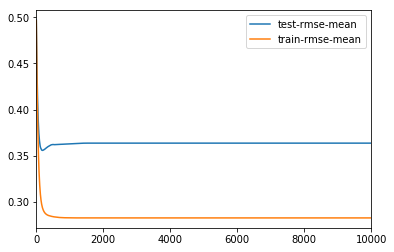

In [16]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
zkn =xgb.cv(xgb_params, xgb_train, num_boost_round=10000, nfold=10, stratified=False, folds=None, metrics=('rmse'), obj=None, feval=None, maximize=False, 
            fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=2019, callbacks=None, shuffle=True)
zkn.loc[0:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.savefig('aim2_rmse')


In [11]:
xgb_train

In [ ]:
# xgb.plot_importance(model_xgb)

In [ ]:

plt.hist([np.round(test_pred_xgb),y_test],20)
plt.legend(['Prediction','True value'])
plt.savefig('aim2')

In [15]:
import lightgbm as lgb
import matplotlib.pyplot as plt

lgb_params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
#           'max_depth': 9,
          'learning_rate': 0.004,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_samples': 150,
#           'min_child_weight': 0.02,
#           'lambda_l2': 0.0475,
#           'verbosity': -1,
          'data_random_seed': 17
    
}

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
evals_result = {}
gbm = lgb.train(lgb_params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,
                verbose_eval=100,
                early_stopping_rounds=20)
test_pred_lgbm = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print(accuracy_score(y_test, np.round(test_pred_lgbm).astype(np.int8)))

Training until validation scores don't improve for 20 rounds.
[100]	training's rmse: 0.365459	valid_1's rmse: 0.394734
[200]	training's rmse: 0.343647	valid_1's rmse: 0.377596
[300]	training's rmse: 0.333058	valid_1's rmse: 0.370135
[400]	training's rmse: 0.327828	valid_1's rmse: 0.366706
Early stopping, best iteration is:
[476]	training's rmse: 0.32508	valid_1's rmse: 0.364917
0.8128342245989305


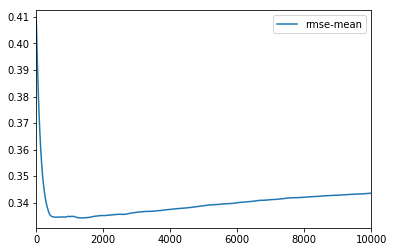

In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
zkn2 = lgb.cv(lgb_params,lgb_train,num_boost_round=10000,nfold=10)
df = pd.DataFrame(data=zkn2)
df.loc[0:,["rmse-mean"]].plot()


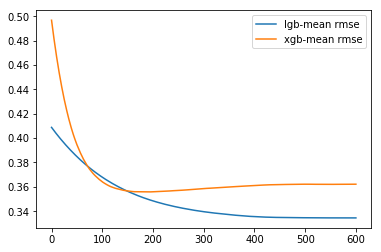

In [24]:
plt.plot(df.loc[0:600,["rmse-mean"]],label='lgb-mean rmse')
plt.plot(zkn.loc[0:600,["test-rmse-mean"]],label='xgb-mean rmse')
plt.legend()
plt.savefig('kfold')

In [29]:
from catboost import Pool, CatBoostRegressor
cat_params = {'depth': 8,
              'eta': 0.01,
#               'random_strength': 1.5,
#               'one_hot_max_size': 2,
#               'reg_lambda': 6,
              'od_type': 'Iter',
#               'fold_len_multiplier': 2,
              'bootstrap_type': "Bayesian",
#               'bagging_temperature': 1,
              'random_seed': 1337,
              # 'verbose_eval': 100,
#               'early_stopping_rounds': 500,
              'num_boost_round': 20000}


foo = X_train.dtypes
cat_feature_names = foo[foo == "category"]
cat_features = [X_train.columns.get_loc(c) for c in X_train.columns if c in cat_feature_names]
# watchlist3 = Pool(X_train, y_train)
print('training CatB:')

model3 = CatBoostRegressor(cat_features=list(cat_features), **cat_params)
# train the model
model3.fit(X_train, y_train,verbose=1000)
# make the prediction using the resulting model
test_pred3 = model3.predict(X_test)
print(accuracy_score(y_test, np.round(test_pred3).astype(np.int8)))

training CatB:
0:	learn: 0.8804808	total: 60.2ms	remaining: 20m 4s
1000:	learn: 0.3156558	total: 3.75s	remaining: 1m 11s
2000:	learn: 0.3111874	total: 7s	remaining: 1m 2s
3000:	learn: 0.3078004	total: 10s	remaining: 56.8s
4000:	learn: 0.3060599	total: 13.3s	remaining: 53.4s
5000:	learn: 0.3044311	total: 16.3s	remaining: 48.7s
6000:	learn: 0.3031389	total: 20s	remaining: 46.6s
7000:	learn: 0.3016471	total: 23s	remaining: 42.7s
8000:	learn: 0.3007427	total: 26.5s	remaining: 39.7s
9000:	learn: 0.3000043	total: 29.4s	remaining: 36s
10000:	learn: 0.2995094	total: 32.9s	remaining: 32.9s
11000:	learn: 0.2990461	total: 36s	remaining: 29.5s
12000:	learn: 0.2987102	total: 39.3s	remaining: 26.2s
13000:	learn: 0.2982654	total: 42.2s	remaining: 22.7s
14000:	learn: 0.2979313	total: 45.6s	remaining: 19.5s
15000:	learn: 0.2976762	total: 49s	remaining: 16.3s
16000:	learn: 0.2974121	total: 52.1s	remaining: 13s
17000:	learn: 0.2971005	total: 55.5s	remaining: 9.79s
18000:	learn: 0.2968512	total: 59.8s	rem

In [30]:

from sklearn.svm import SVC,LinearSVC
 
clf = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


clf.fit(X_train, y_train)
result = clf.predict(X_test) 

accuracy_score(result,y_test)
# print(clf.predict([[-0.8, -1]]))


0.8128342245989305

In [41]:
import tensorflow as tf

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

train_dataset = Xtrain
test_dataset = Xtest
train_labels = ytrain
test_labels = ytest

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Generate dummy data
x_train = Xtrain
y_train = ytrain
x_test = Xtest
y_test = ytest

model = Sequential()
model.add(Dense(32, input_dim=8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=50,
          batch_size=128)

score = model.evaluate(x_test, y_test, batch_size=128)


1.13.1
Epoch 1/50
446/446 [==============================] - 0s 607us/sample - loss: 0.5588 - acc: 0.7848
Epoch 2/50
446/446 [==============================] - 0s 15us/sample - loss: 0.5655 - acc: 0.7848
Epoch 3/50
446/446 [==============================] - 0s 15us/sample - loss: 0.5638 - acc: 0.7870
Epoch 4/50
446/446 [==============================] - 0s 18us/sample - loss: 0.5861 - acc: 0.7870
Epoch 5/50
446/446 [==============================] - 0s 19us/sample - loss: 0.5458 - acc: 0.7870
Epoch 6/50
446/446 [==============================] - 0s 16us/sample - loss: 0.5453 - acc: 0.7870
Epoch 7/50
446/446 [==============================] - 0s 17us/sample - loss: 0.5505 - acc: 0.7870
Epoch 8/50
446/446 [==============================] - 0s 18us/sample - loss: 0.5599 - acc: 0.7870
Epoch 9/50
446/446 [==============================] - 0s 21us/sample - loss: 0.5377 - acc: 0.7870
Epoch 10/50
446/446 [==============================] - 0s 18us/sample - loss: 0.5470 - acc: 0.7870
Epoch 11/50

In [164]:
classes = model.predict(X_test, batch_size=128)

In [6]:
ytrain = np.ones((446),dtype=np.int16)
Xtrain = np.ones((446,8),dtype=np.int16)

for i in range(446):
    X_train
    ytrain[i] = y_train[i]
    Xtrain[i] = X_train.values[0]

In [7]:
len(y_test)
ytest = np.ones((187),dtype=np.int16)
Xtest = np.ones((187,8),dtype=np.int16)
for i in range(187):
    ytest[i] = y_test[i]
    Xtest[i] = X_test.values[0]

In [8]:
Xtrain

array([[1, 0, 2, ..., 2, 0, 1],
       [1, 0, 2, ..., 2, 0, 1],
       [1, 0, 2, ..., 2, 0, 1],
       ...,
       [1, 0, 2, ..., 2, 0, 1],
       [1, 0, 2, ..., 2, 0, 1],
       [1, 0, 2, ..., 2, 0, 1]], dtype=int16)